In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Problem 1

*$QR$ decomposition keeps one from squaring the condition number if you explicitly form $A^TN^{-1}A$. This is $A=QR$ where $Q$ is an orthogonal rectangular matrix (so $QQ^T=I)$ and $R$ is a triangular matrix. What is the least squares solution for fit parameters when using $QR$ to factor $A$?* 

*Write code to fit polynomials using both the classical expression and $QR$ factorization. Show for some case that the $QR$ fit behaves better than the classical fit. Set $N=I$ for the fit, make sure the $QR$ solution shows how you would use it (use Cholesky).*

The linear least squares equation is $A^TN^{-1}Am = A^TN^{-1}d$

Solving for the fit parameters gives $m = (A^TN^{-1}A)^{-1}(A^TN^{-1}d)$

For $N=I$, this gives $m = (A^TA)^{-1}A^Td$

The $QR$ decomposition where $A=QR$ gives the linear least squares equation: $(QR)^TN^{-1}(QR)m = (QR)^TN^{-1}d$

Expanding this gives $R^TQ^TN^{-1}QRm = R^T Q^T N^{-1}d$

$R$ is triangular, so assume it's invertible (which is the case if the diagonal elements are nonzero) so $RR^T=I$, then $Q^TN^{-1}QRm = Q^T N^{-1}d$

If $(Q^TN^{-1}QR)$ is invertible then the fit parameters are $m = (Q^TN^{-1}QR)^{-1}Q^T N^{-1}d$

For the case when $N=I$, this becomes $m = (Q^TQR)^{-1}Q^T d$

Since $Q$ is orthogonal, $QQ^T = I$ which leaves $m = R^{-1}Q^Td$


In [2]:
# Both of these use N=I

def classical_fitp(x,d,order):
    """
    Parameters:
    x = x values
    d = data corresponding to x values
    order = order of the polynomial to fit to the data
    
    Returns:
    fitp = fit parameters of model m where m = (A^T A)^-1 (A^T d)
    pred = predicted data from the classical fit
    """
    
    # Generate matrix A: columns of A are x^(column index)
    n = len(d)
    A = np.empty([n,order+1])
    for i in range(order+1):
        A[:,i] = x**i
        
    # find the model m (fit parameters) that solve linear 
    # least squares equation for the case when N=I
    lhs = A.T@A
    fitp = np.linalg.inv(lhs)@(A.T@d)
    pred = A@fitp
    
    return fitp, pred
 
def qr_fitp(x,d,order):
    """
    Parameters:
    x = x values
    d = data corresponding to x values
    order = order of the polynomial to fit to the data
    
    Returns:
    fitp = fit parameters of the model m where m = R^-1 (Q^T d)
    pred = predicted data from the QR fit
    """
    
    # Generate matrix A: columns of A are x^(column index)
    n = len(d)
    A = np.empty([n,order+1])
    for i in range(order+1):
        A[:,i] = x**i
        
    # Use linalg.qr to decompose A
    Q, R = np.linalg.qr(A)
    
    # find the model m (fit parameters) that solve linear 
    # least squares equation for the case when N=I
    lhs = R
    fitp = np.linalg.inv(lhs)@(Q.T@d)
    pred = Q@R@fitp
    
    return fitp, pred

polynomial coefficients are : [ 0.74405509  0.         -0.68824439  1.66684859  0.        ]


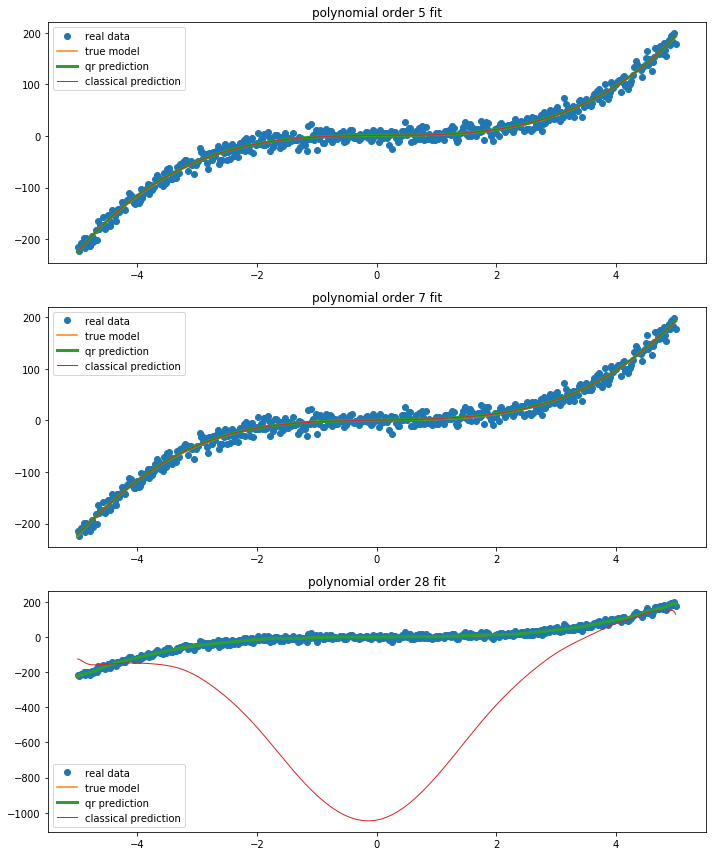

In [3]:
# generate coefficients for a polynomial: 
# say 4th order with some zero coefficients
coeffs = np.random.normal(0,1,size=5)
coeffs[1], coeffs[4] = 0, 0
fun = lambda x: np.sum([coeffs[i]*x**i for i in range(5)],axis=0)
print('polynomial coefficients are :', coeffs)

# get x and y data, add some random noise with sigma=50
x = np.linspace(-5,5,501)
y = fun(x) + np.random.normal(0,10,size=(len(x)))

# try a few different choices of orders to fit to
orders = [5,7,28]

# plot!
fig, axs = plt.subplots(len(orders),1,figsize=(10,12),tight_layout=True)
axs = axs.ravel()
for i in range(len(orders)):
    
    # get the predicted data from the classical and qr fits
    order = orders[i]
    fitp_classical, pred_classical = classical_fitp(x,y,order)
    fitp_qr, pred_qr = qr_fitp(x,y,order)
    
    # plot results
    axs[i].plot(x, y, ls='', marker='o', label='real data')
    axs[i].plot(x, fun(x), label='true model')
    axs[i].plot(x, pred_qr, lw=3, label='qr prediction')
    axs[i].plot(x, pred_classical, lw=1, label='classical prediction')
    axs[i].legend()
    axs[i].set_title('polynomial order {} fit'.format(order))

Fig: The $QR$ and classical fits both agree with the real data pretty well. The classical fails pretty badly for much a much higher order polynomial fit whereas $QR$ still does alright.

Fitting with $QR$ decomposition is similar, but leave $N$ in the linear least squares equation. I make $N$ using the Gaussian correlated noise code from lecture 4 to get correlated data (correlating a polynomail signal plus noise) then do a $QR$ fit.

In [4]:
# this uses a general N

def qr_fitp_Cholesky(x,d,N,order):
    """
    Parameters:
    x = x values
    d = data corresponding to x values
    N = general noise matrix
    order = order of the polynomial to fit to the data
    
    Returns:
    fitp = model m where m = (Q^T N^-1 QR)^-1 (Q^T N^-1 d)
    pred = predicted data from the QR fit
    """
    
    # Generate matrix A: columns of A are x^(column index)
    n = len(d)
    A = np.empty([n,order+1])
    for i in range(order+1):
        A[:,i] = x**i
        
    # Use linalg.qr to decompose A
    Q, R = np.linalg.qr(A)
    
    # Invert the noise matrix to get fit parameters and predicted model
    Ninv = np.linalg.inv(N)
    
    # get fit parameters and predicted model that solve 
    # linear least squares equation for general N
    lhs = Q.T@(Ninv@(Q@R))
    rhs = Q.T@(Ninv@dat)
    fitp = np.linalg.inv(lhs)@rhs
    pred = Q@R@fitp
    
    return fitp, pred

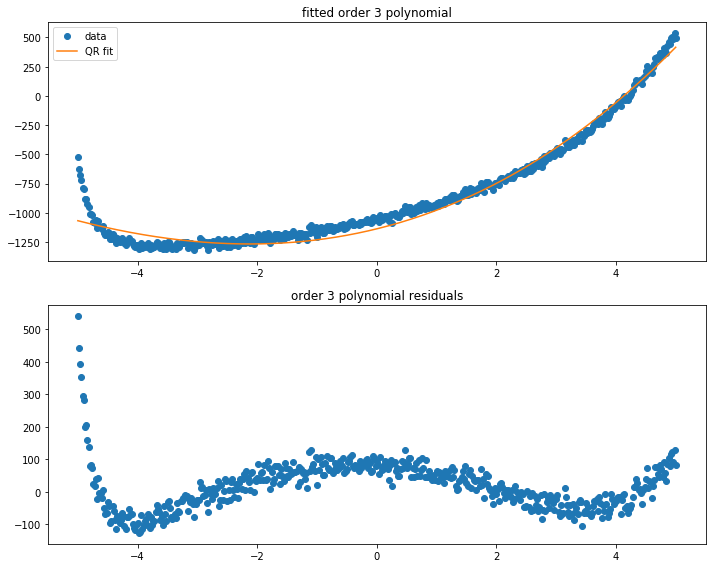

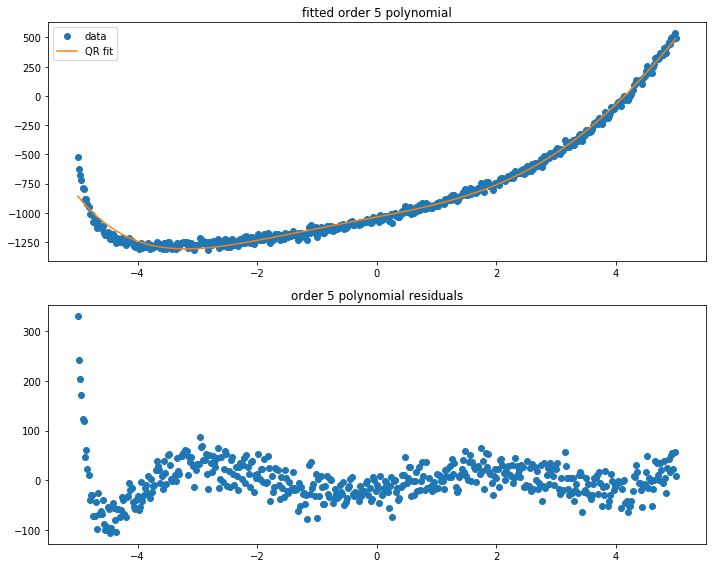

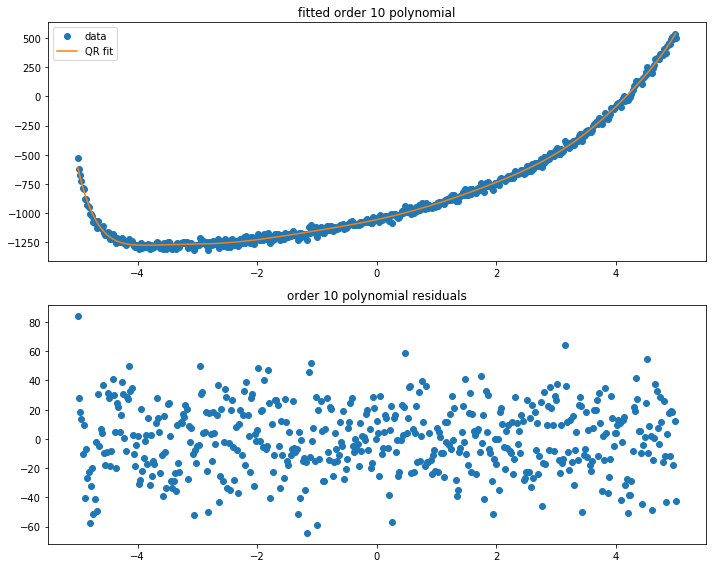

In [6]:
# generate a N using Cholesky, keep the same x and y as above 
# but rotate y using the L matrix to make correlated data 

# this code draws from "lecture4/gauss_corrnoise.py"
xmat=np.outer(x,np.ones(len(x)))
dx=xmat-xmat.T
sig=5 # standard deviation for correlated noise
mycorr=np.exp(-0.5*dx**2/sig**2)
# add a bit of noise to diagonal for stability
mycorr=mycorr+5*np.eye(len(x)) 
L=np.linalg.cholesky(mycorr)

# get y data using L
dat = L@y.T

# make the noise matrix using N=LL^T
N = L@L.T

# loop through a few choices of orders for the polynomial fit
orders = [3,5,10]
for i, order in enumerate(orders):

    # get prediction from QR fit using N from Cholesky
    fitp_N, pred_N = qr_fitp_Cholesky(x,dat,N,order)
    
    # plot results and residuals
    fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,8),tight_layout=True)
    ax1.plot(x, dat, ls='', marker='o', label='data')
    ax1.plot(x, pred_N, label='QR fit')
    ax2.plot(x, dat-pred_N, ls='', marker='o')
    ax2.set_title('order {} polynomial residuals'.format(order))
    ax1.legend()
    ax1.set_title('fitted order {} polynomial'.format(order))

Fig: The residuals have comparable magnitudes, but order 3 and 5 are bad fits (residuals still have a lot of structure). Order 10 looks ok though.

# Problem 2

*Chebyshev polynomials: $T_n = cos(n*arccos(x))$, defined in the domain (-1,1). They are generated with the recurrence relation $T_{n+1} = 2sT_n - T_{n-1}$ with $T_0=1$ and $T_1=x$.*

*(a) Write a python code that fits a Chebyshev polynomial to exp(x) from -1 to 1, with some fine sampling of x. Show that as the polynomial order gets large, the fit stays stable.*

*(b) Chebyshev polynomials have y values bounded by +/-1. If we truncate a polynomial fit, the maximum error is bounded by the sum of the absolute value of the coefficients we truncated. Use this to find a "least bad" fit to exp(x): fit 6th order (7 terms) Chebyshev to exp(x) on (-1,1). What is the RMS error and the maximum error? Fit a much higher order Chebyshev fit to exp(x). If the fit is truncated (use only first 7 terms), what are the RMS and max errors? How does the max error agree with prediction based on the terms we ignored? (Should find RMS error goes up by 15% but max error goes down by more than a factor of 2).*

In [7]:
def chebyfit(order, truncate=False):
    """
    Parameters:
    order = order of the Chebyshev polynomial fit
    truncate = False when not truncating the Chebyshev polynomial. If 
    not False then truncate = order of truncated Chebyshev polynomials. 
    
    Returns:
    cheb_poly = Chebyshev polynomial fitted to exp(x)
    pred = prediction based on Chebyshev fit to exp(x)
    x = x values
    y = y values for y=exp(x)
    err_rms = RMS error
    err_max = maximum error
    """
    
    # Generate x and y data
    npts = 1001
    x = np.linspace(-1,1,npts)
    y = np.exp(x)
    
    # Initialize Chebyshev polynomial (T), fill nth columns with T_n
    # starting with T_0 = 1, T_1 = x. This acts as "A" in A^TAm = A^Ty
    T_mat = np.empty([npts,order+1])
    T_mat[:,0] = 1
    T_mat[:,1] = x
    for i in range(1,order):
        T_mat[:,i+1] = 2*x*T_mat[:,i] - T_mat[:,i-1]
    
    # If we choose to truncate to a lower order:
    if truncate != False:
        print('truncating to {}th order'.format(truncate))
        cheb_poly = T_mat[:,:truncate+1]
    elif truncate == False:
        cheb_poly = T_mat
        
    # Get the prediction of exp(x) from the Chebyshev fit
    lhs = cheb_poly.T@cheb_poly
    fitp = np.linalg.inv(lhs)@(cheb_poly.T@y)
    pred = cheb_poly@fitp
    
    # Calculate the RMS error
    rms_err = np.sqrt(np.mean((y-pred)**2))
    
    # Calculate the max error
    max_err = np.sum(np.abs(y-pred))
    
    return pred, x, y, rms_err, max_err

## (a)

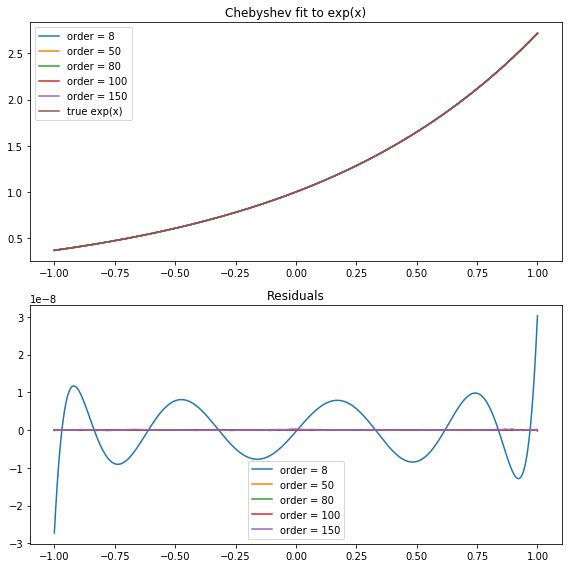

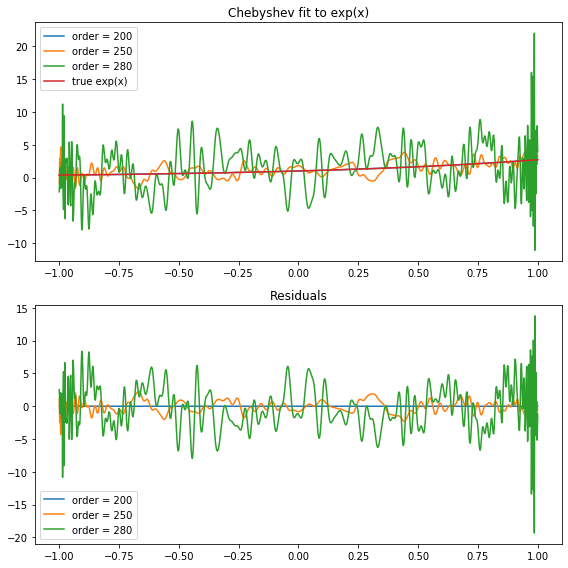

In [10]:
# Take a few choices of Chebyshev polynomial orders
orders = [8,50,80,100,150]

# Plot results
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,8), tight_layout=True)
for i in range(len(orders)):
    
    # get Chebyshev fits, x, and y for different orders
    order = orders[i]
    cheb, x, y, rms_err, max_err = chebyfit(order)
    
    # plot x, y, predicted y, and the residuals
    ax1.plot(x, cheb, label='order = {}'.format(order))
    ax1.set_title('Chebyshev fit to exp(x)')
    ax2.plot(x, y-cheb, label='order = {}'.format(order))
    ax2.set_title('Residuals')
ax1.plot(x, y, label='true exp(x)')
ax1.legend()
ax2.legend()

# Now choose much higher orders (where it breaks down)
orders = [200,250,280]

# Plot results
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,8), tight_layout=True)
for i in range(len(orders)):
    
    # get Chebyshev fits, x, and y for different orders
    order = orders[i]
    cheb, x, y, rms_err, max_err = chebyfit(order)
    
    # plot x, y, predicted y, and the residuals
    ax1.plot(x, cheb, label='order = {}'.format(order))
    ax1.set_title('Chebyshev fit to exp(x)')
    ax2.plot(x, y-cheb, label='order = {}'.format(order))
    ax2.set_title('Residuals')
ax1.plot(x, y, label='true exp(x)')
ax1.legend()
ax2.legend()

Fig: At very high order (150), the Chebyshev fit is still stable (the fits are all on top of each other and accurate to around 1e-8). At around order=200 and higher, the fits start to break down.

## (b)

In [11]:
# get 6th order Chebyshev fit (and errors) to exp(x)
cheb6, x, y, rms_err6, max_err6 = chebyfit(6)
print('6th order Chebyshev fit: RMS error = {}, max error = {}'.format(rms_err6, max_err6))

# get a 25th order Chebyshev fit (and erros) to exp(x)
cheb25, x, y, rms_err25, max_err25 = chebyfit(25)
print('25th order Chebyshev fit: RMS error = {}, max error = {}'.format(rms_err25, max_err25))

# get a 100th order Chebyshev fit (and erros) to exp(x)
# and truncate to 6th order
cheb_trunk, x, y, rms_err_trunk, max_err_trunk = chebyfit(25,truncate=6)
print('25th order Chebyshev fit, truncated to 6th order: RMS error = {}, max error = {}'.format(rms_err_trunk, max_err_trunk))

# calculate how much the errors have changed compared to keeping 
# all 101 terms terms in the higher order Chebyshev fit
rms_err_reduce = 100*(rms_err25-rms_err_trunk)/(rms_err25+rms_err_trunk)
max_err_reduce = 100*(max_err25-max_err_trunk)/(max_err25+max_err_trunk)
print('RMS is reduced by {}%, max is reduced by {}% when truncating from 25th order Chebyshev to 6th order.'.format(rms_err_reduce, max_err_reduce))

6th order Chebyshev fit: RMS error = 1.985283248275297e-06, max error = 0.0017065518761679166
25th order Chebyshev fit: RMS error = 1.6517003983564386e-15, max error = 9.666156763898925e-13
truncating to 6th order
25th order Chebyshev fit, truncated to 6th order: RMS error = 1.985283248275297e-06, max error = 0.0017065518761679166
RMS is reduced by -99.99999983360559%, max is reduced by -99.9999998867171% when truncating from 25th order Chebyshev to 6th order.


I've messed up the calculation somewhere. I'm not sure if it's with the error calculations or the truncating...

# Problem 3

*Write a python script that generates random correlated data by taking the eigenvalues/eigenvectors of a noise matrix, and show that if you average over many realizations, that $<dd^T>$ converges to the noise matrix. One easy matrix to work with would be $N_{ij} = 1 + \delta_{i,j}$ (it's 1 everywhere except 2 along the diagonal), but code doing the actual realization of the noise should be general.*

We had $\tilde{N} = VNV^T$ where $\tilde{N}$ was the correlated noise matrix and $V$ is orthogonal so $VV^T = V^TV = I$.

Now let $N$ (1 everywhere and 2 along the diagonal) be the noise matrix. If we do an eigendecomposition of $N$, we have $N = V E V^{-1}$ where $E$ is a diagonal matrix of eigenvalues and $V$ is the matrix of eigenvectors in its columns. Then $d = Vd_{old}$ generates correlated data. 

$d_{old}$ is the random uncorrelated noise. This is drawn from a Gaussian distribution with zero mean and $\sigma_i = \sqrt{|e_i|}$ where $e_i$ is the i$^{th}$ eigenvalue of $E$. (Each of these is the variance of the Gaussian noise, which together make up the diagonal elements of the noise matrix in uncorrelated space).

Compare $N$ to the outer product of $d$ and $d^T$ averaged over all noise realizations.

In [12]:
def get_correlated_data(N):
    """
    Parameters:
    N = general noise matrix 
    
    Returns:
    ddT = outer product of data (noise) which is correlated via eigendecomposition of N
    noise_corr = correlated data (noise)
    """
    
    # Eigendecomposition of N: use linalg.eigh so
    # there aren't a bunch of imaginary numbers
    e,V = np.linalg.eigh(N)
    E = np.diag(e)
    
    # Generate random Gaussian noise with sigma = sqrt(eigenvalues)
    noise_uncorr = np.random.normal(0,np.sqrt(np.abs(e)))
    
    # Correlate the noise by rotating with the matrix of eigenvectors
    noise_corr = V@noise_uncorr
    
    # Get the outer product of the correlated noise
    ddT = np.outer(noise_corr, noise_corr.T)
    
    return ddT, noise_corr

Text(0.5, 1.0, 'residuals')

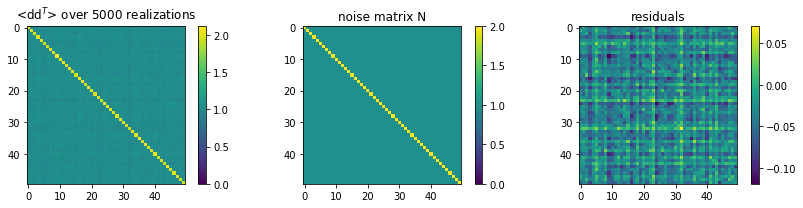

In [13]:
# Find the average: <dd^T> for many realizations

# say we do 5000 noise realizations
nruns = 5000

# set length of data 
n = 50

# use N = 1 + delta_{i,j}
N = np.ones([n,n])
N += np.eye(n)

# loop through each realization of the noise and save ddT
ddT_all = []
for i in range(nruns):
    
    # get ddT and correlated noise
    ddT_new, noise_new = get_correlated_data(N)
    ddT_all.append(ddT_new)
    
# get the average <dd^T>
ddT_avg = np.sum(ddT_all, axis=0)/nruns

# plot the results and compare to noise matrix N
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,3), tight_layout=True)
im1 = ax1.imshow(ddT_avg,vmin=0)
im2 = ax2.imshow(N,vmin=0)
im3 = ax3.imshow(N-ddT_avg)
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
ax1.set_title('<dd$^T$> over {} realizations'.format(nruns))
ax2.set_title('noise matrix N')
ax3.set_title('residuals')

Fig: The average $<dd^T>$ is close to the noise matrix $N$ (they are nearly identical along the diagonal, with some noise in the off-diagonal elements).

# Problem 4

*Use a noise matrix with 2 components (diagonal plus correlated noise with a correlation length): $N_{ij} = a exp(-\frac{(i-j)^2}{2 \sigma^2}) + (1-a) \delta (i-j)$.*

*The variance of each point is always 1, but if $a$ is very small then the data are nearly uncorrelated. If $a$ is very large then they are almost perfectly correlated. If $\sigma$ is large then the data points will be correlated over large distances. If $\sigma$ is very small they will only be correlated with their near neighbors.*

*(a) For 1000 points (x from 0 to 999) and a Gaussian source with amplitude 1 and $\sigma_{src}=50$ in the center. Take values of $a$ to be (0.1,0.5,0.9) and $\sigma$ to be (5,50,500). Write a script that generates the noise matrix for these values and uses it to report the error bar on the fit amplitude for each pair of $a$ and $\sigma$. Check that the error for $a=0.5$ and $\sigma = 5$ is 0.276.*

*(b) Explain why the error bars behave the way they do. Which set of parameters has the worst/best error bar? What sort of noise should we be worried about? Use problem 3 code to generate noise realizations of these noise matrices and plot the realizations with/without a signal added in.*

## (a)

The error in the fitted amplitude is $1/\sqrt{A^T N^{-1} A}$, where $A$ is the Gaussian signal (single parameter model).

In [15]:
# Construct the noise matrix N and calculate the error in 
# the fitted amplitude using the above equation

# set rows and columns of N (number of points in x)
npts=1000

# set all a, sigma for the noise matrix
a_all = [0.1,0.5,0.9]
sigma_all = [5,50,500]

# initialize empty matrix of amplitude errors
errs_all = np.empty([len(a_all),len(sigma_all)])

# initialize empty matrix of noise matrices
N_all = np.empty([len(a_all),len(sigma_all),npts,npts])

# loop through a and sigma and save the errors and N
for a_i, a in enumerate(a_all):
    for sigma_i, sigma in enumerate(sigma_all):

            # fill rows and columns of N
            N = np.empty([npts,npts])
            N_diag = (1-a)*np.eye(npts)
            for i in range(npts):
                for j in range(npts):
                    N[i,j] = a*np.exp(-(i-j)**2/(2*sigma**2)) + N_diag[i,j]
            
            # save all noise matrices
            N_all[a_i,sigma_i,:,:] = N
            
            # gaussian source with amplitude 1, sigma=50, at center
            x = np.linspace(0,999,npts)
            mu = x[500]
            sigma_sig = 50
            gauss = np.exp(-(x-mu)**2/(2*sigma_sig**2))

            # get the error on the fitted amplitude
            Ninv = np.linalg.inv(N)
            err = 1/np.sqrt(gauss.T@Ninv@gauss)
            
            # save errors for each a, sigma
            errs_all[a_i,sigma_i] = err
            
            # print results
            print('a = {}, sigma = {}. Error on fitted amplitude = {}'.format(a,sigma,err))

a = 0.1, sigma = 5. Error on fitted amplitude = 0.15576335487646098
a = 0.1, sigma = 50. Error on fitted amplitude = 0.33774489562315874
a = 0.1, sigma = 500. Error on fitted amplitude = 0.12757498758982014
a = 0.5, sigma = 5. Error on fitted amplitude = 0.27599935080333926
a = 0.5, sigma = 50. Error on fitted amplitude = 0.7140544770562315
a = 0.5, sigma = 500. Error on fitted amplitude = 0.10066392140726645
a = 0.9, sigma = 5. Error on fitted amplitude = 0.3578952599636378
a = 0.9, sigma = 50. Error on fitted amplitude = 0.9499319468584297
a = 0.9, sigma = 500. Error on fitted amplitude = 0.04892549466815376


Sanity check: for $a=0.5$, $\sigma=5$ the error is 0.276.

The worst error bars are for $a=0.9$ and $\sigma=50$. The best are for $a=0.9$ and $\sigma=500$.

## (b)

Plot the data (noise, noise plus signal) $<dd^T>$ averaged over 100 realizations with and without the Gaussian signal added. Also plot the data (noise, signal plus noise, signal) for one realization as well as averaged over all realizations.

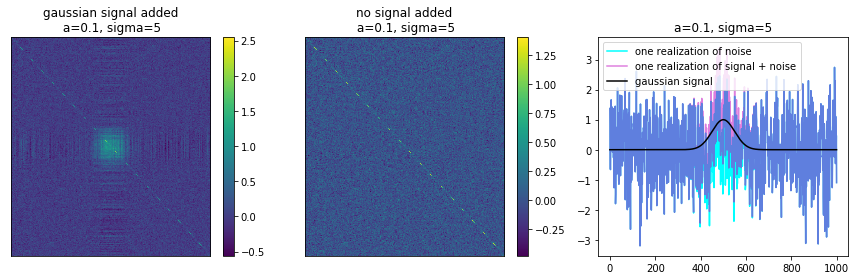

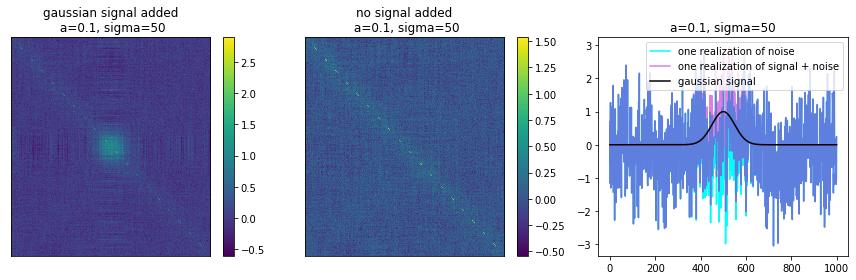

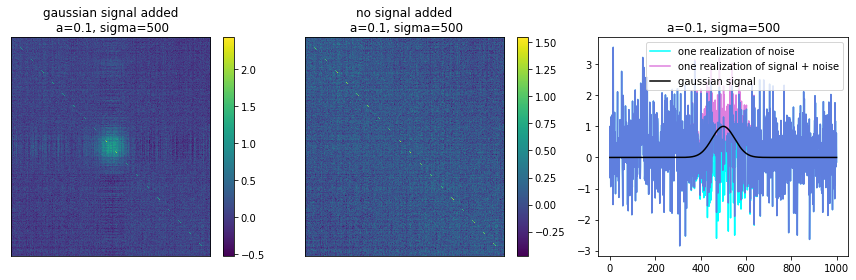

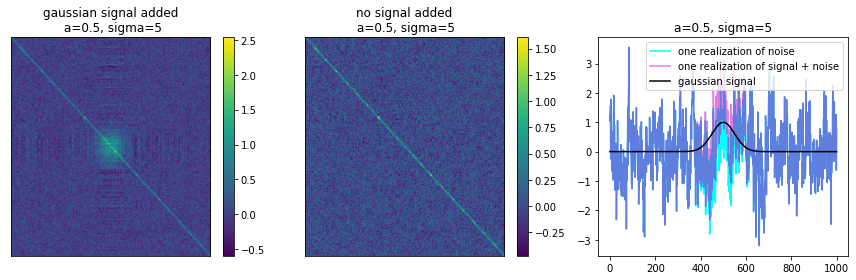

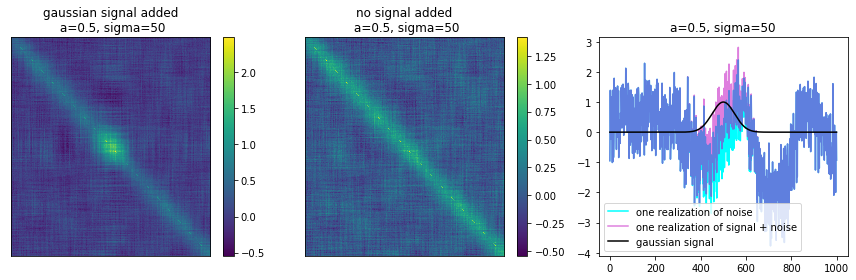

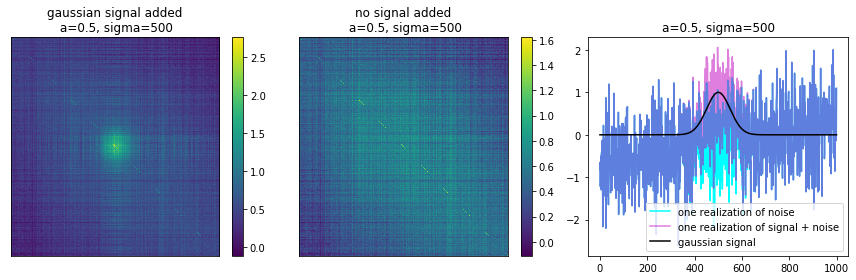

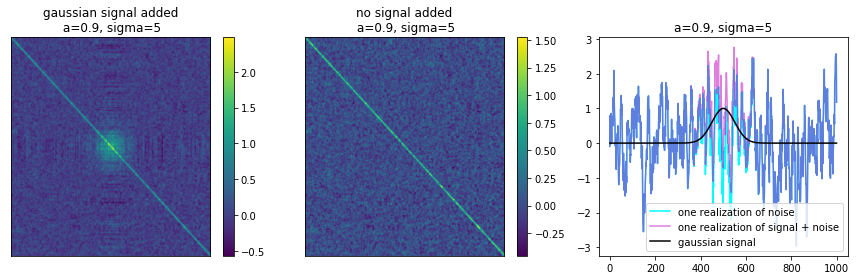

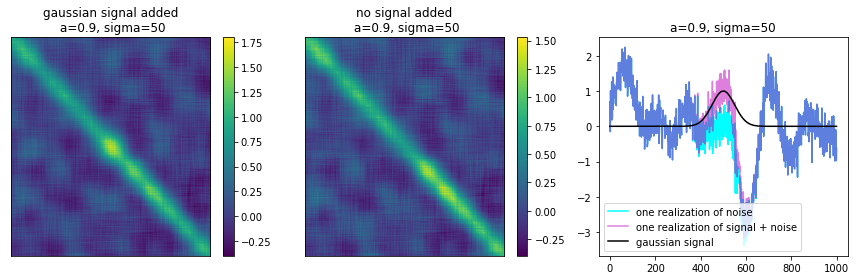

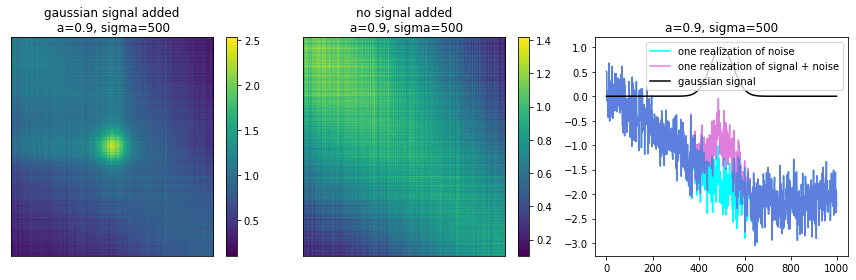

In [16]:
# loop through a and sigma and get the noise realizations
for a_i, a in enumerate(a_all):
    for sigma_i, sigma in enumerate(sigma_all):
        
        # set N (from before)
        N = N_all[a_i,sigma_i,:,:]
        
        # average over 100 realizations
        nreal = 100
        
        # realizations of noise, signal, and signal+noise (1 dimension and ddT)
        ddT_gauss_all, ddT_all, signal_noise_all = [],[],[]
        for i in range(nreal):
            ddT, noise_corr = get_correlated_data(N)
            signal_noise = gauss + noise_corr
            ddT_mat_gauss = np.outer(signal_noise, signal_noise.T)
            ddT_gauss_all.append(ddT_mat_gauss)
            ddT_all.append(ddT)
            signal_noise_all.append(signal_noise)
            
        # get the averages
        ddT_gauss_avg = np.sum(ddT_gauss_all, axis=0)/nreal
        signal_noise_avg = np.sum(signal_noise_all, axis=0)/nreal
        ddT_avg = np.sum(ddT_all, axis=0)/nreal
        
        # plot results
        fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,4),tight_layout=True)
        im1 = ax1.imshow(ddT_gauss_avg,aspect='auto')
        im2 = ax2.imshow(ddT_avg,aspect='auto')
        ax3.plot(noise_corr, c='cyan', label='one realization of noise')
        ax3.plot(signal_noise, c='m', alpha=0.5, label='one realization of signal + noise')
        ax3.plot(gauss, c='k', label='gaussian signal')
        ax3.legend()
        fig.colorbar(im1, ax=ax1)
        fig.colorbar(im2, ax=ax2)
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax1.set_title('gaussian signal added\n a={}, sigma={}'.format(a,sigma))
        ax2.set_title('no signal added\n a={}, sigma={}'.format(a,sigma))
        ax3.set_title('a={}, sigma={}'.format(a,sigma))

Fig: $<dd^T>$ where $d$ = noise with the Gaussian signal added, averaged over 100 noise realizations (left). $<dd^T>$ where $d$ = noise, averaged over 100 noise realizations (middle). One realization of the noise, signal + noise, signal (right). Each row has its own $\sigma$, $a$.

I think that fitting the amplitude of the Gaussian signal (which is the bright center spot in all the leftmost plots) would be more difficult, and therefore have higher error bars, when that signal is skewed by the correlations (this has the biggest effect for $a=0.9$, $\sigma=50$). In this case the correlation length is the same as the standard deviation of the Gaussian signal ($\sigma_{sig}=50$), which means the noise and signal are easily confused. Similarly, if the bright spot stands out (this is most obvious for $a=0.9$, $\sigma=500$ - there's no bright line along the diagonal like all the other plots) then the amplitude should be easiest to fit for, and therefore have the lowest error bars.

This effect is also obvious in the rightmost plots: the Gaussian signal stands out the most in the realization of signal plus noise against the noise for $a=0.9$ and $\sigma=500$, meaning the amplitude should be easiest to fit for. The Gaussian signal is pretty much indistinguishable from the noise for $a=0.9$ and $\sigma=50$ and the amplitude is surely difficult to fit for.

Since the highly correlated data (largest $a=0.9$) has both the lowest and the highest error bars, this suggests that very correlated data alone is not something we should be worried about. Data with correlations lengths equal or close to the standard deviation of the signal have the highest error bars. This is the most worrying type of noise because it will give large error bars for the model fits. Data with very large correlation lengths have the smallest error bars, which is the least worrying because the model we're fitting won't be affected by such large-scale effects.